In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.training_utils import multi_gpu_model


sns.set(style='white', context='notebook', palette='deep')

/home/yunhao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("input/train + dev.csv")

In [3]:
train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


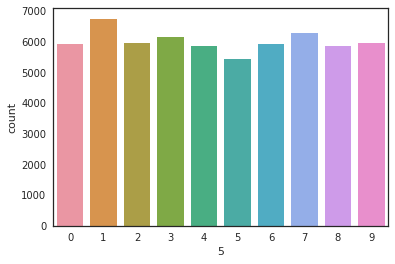

In [5]:
Y_train = train["5"]
X_train = train.drop(labels = ["5"],axis = 1) 

g = sns.countplot(Y_train)

We have similar counts for the 10 digits.

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There are no missing values in dataset.

In [8]:
# Normalize the data
X_train = X_train / 255.0

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [11]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size = 0.1)

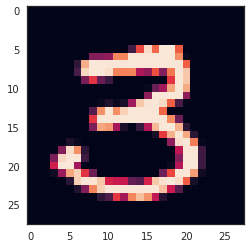

In [12]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [13]:
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (10,10),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (10,10),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.05))


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.05))


model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.15))

model.add(Dense(10, activation = "softmax"))

In [14]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1)

datagen.fit(X_train)

In [15]:
# 0.001 * 30 epoch and 0.00001 * 20 epoch
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.05)
# optimizer = Adagrad(lr=0.001, epsilon=None, decay=0.0)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                 decay=0.007, amsgrad=False)

In [16]:
# Compile the model
model = multi_gpu_model(model, gpus=2)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
epochs = 30
batch_size = 512

In [19]:
%%time
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_dev,Y_dev),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 10s - loss: 0.3496 - acc: 0.8998 - val_loss: 0.1105 - val_acc: 0.9680
Epoch 2/30
 - 8s - loss: 0.0787 - acc: 0.9760 - val_loss: 0.0587 - val_acc: 0.9820
Epoch 3/30
 - 7s - loss: 0.0589 - acc: 0.9817 - val_loss: 0.0549 - val_acc: 0.9850
Epoch 4/30
 - 7s - loss: 0.0519 - acc: 0.9840 - val_loss: 0.0407 - val_acc: 0.9875
Epoch 5/30
 - 8s - loss: 0.0467 - acc: 0.9857 - val_loss: 0.0322 - val_acc: 0.9912
Epoch 6/30
 - 7s - loss: 0.0427 - acc: 0.9868 - val_loss: 0.0345 - val_acc: 0.9903
Epoch 7/30
 - 7s - loss: 0.0376 - acc: 0.9880 - val_loss: 0.0306 - val_acc: 0.9915
Epoch 8/30
 - 8s - loss: 0.0385 - acc: 0.9879 - val_loss: 0.0285 - val_acc: 0.9920
Epoch 9/30
 - 7s - loss: 0.0375 - acc: 0.9878 - val_loss: 0.0290 - val_acc: 0.9922
Epoch 10/30
 - 8s - loss: 0.0346 - acc: 0.9893 - val_loss: 0.0276 - val_acc: 0.9915
Epoch 11/30
 - 8s - loss: 0.0332 - acc: 0.9899 - val_loss: 0.0265 - val_acc: 0.9923
Epoch 12/30
 - 8s - loss: 0.0320 - acc: 0.9898 - val_loss: 0.0276 - val_acc: 0.9922


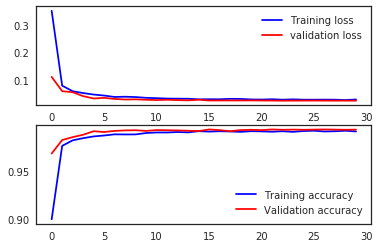

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

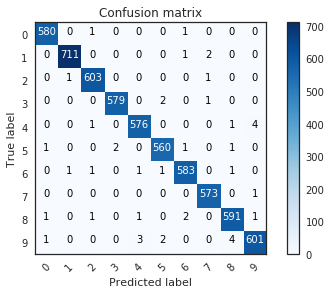

In [21]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_dev)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_dev,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 